In [1]:
import os
os.chdir(r"C:\Local Disk D\BDA_CEP_Part-2")
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import ks_2samp
import pickle


In [2]:
# Load real and synthetic data
real = np.load("data/processed/electricity/test.npy")   # scaled
synth = np.load("outputs/synth/synth_electricity_2000w.npy")  # inverse-scaled

# Load scaler and rescale synthetic data back to scaled domain
scaler = pickle.load(open("data/processed/electricity/scaler.pkl", "rb"))
synth_scaled = scaler.transform(synth.reshape(-1, synth.shape[2])).reshape(synth.shape)


In [3]:
feat_names = open("data/processed/electricity/features.txt").read().splitlines()
f = 0  # feature index to inspect (0..6)


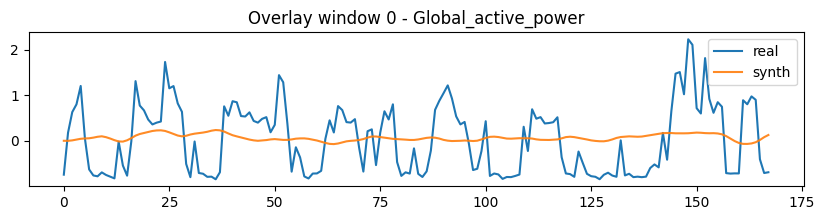

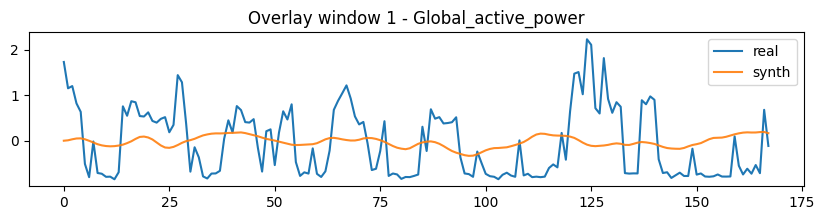

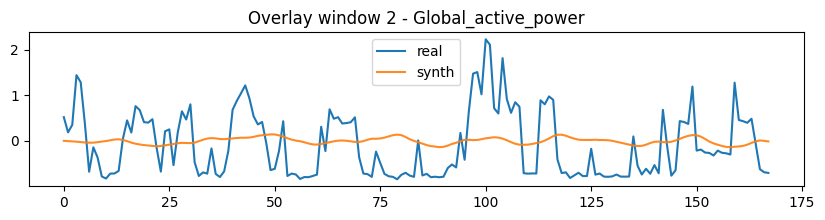

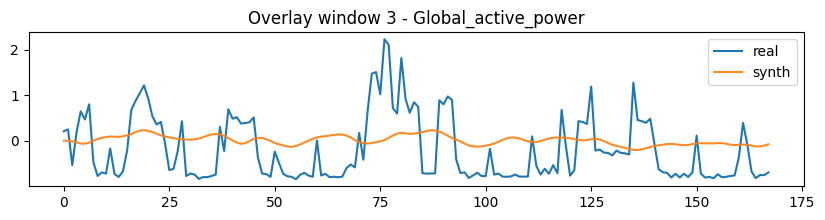

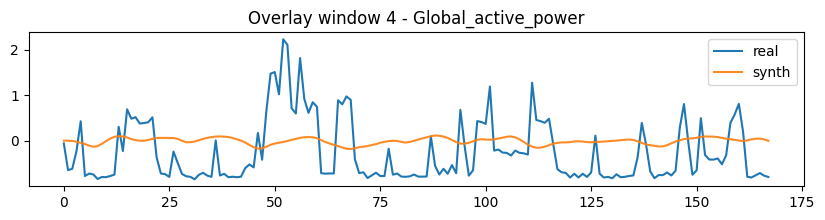

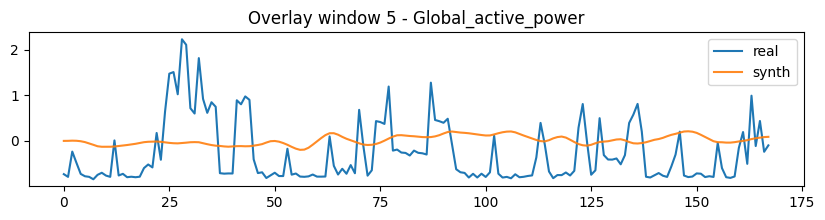

In [4]:
for i in range(6):
    plt.figure(figsize=(10, 2))
    plt.plot(real[i, :, f], label="real")
    plt.plot(synth_scaled[i, :, f], label="synth", alpha=0.9)
    plt.title(f"Overlay window {i} - {feat_names[f]}")
    plt.legend()
    plt.show()


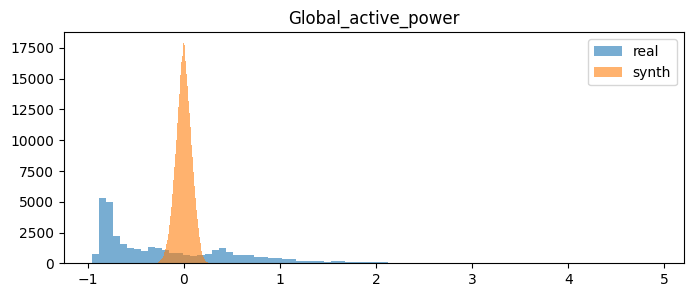

In [5]:
plt.figure(figsize=(8, 3))
plt.hist(real[:, :, f].ravel(), bins=80, alpha=0.6, label='real')
plt.hist(synth_scaled[:, :, f].ravel(), bins=80, alpha=0.6, label='synth')
plt.title(feat_names[f])
plt.legend()
plt.show()


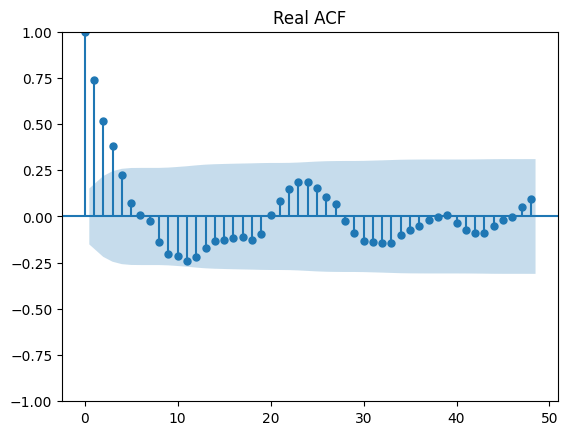

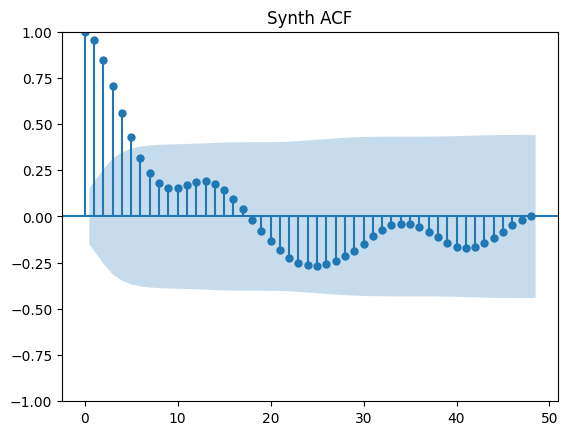

In [6]:
plot_acf(real[0, :, f], lags=48, title="Real ACF")
plt.show()

plot_acf(synth_scaled[0, :, f], lags=48, title="Synth ACF")
plt.show()


In [7]:
for fi, name in enumerate(feat_names):
    ks = ks_2samp(real[:, :, fi].ravel(), synth_scaled[:, :, fi].ravel())
    print(name, "KS stat:", ks.statistic, "pval:", ks.pvalue)


Global_active_power KS stat: 0.5790450837742505 pval: 0.0
Global_reactive_power KS stat: 0.4091976410934744 pval: 0.0
Voltage KS stat: 0.5137001763668431 pval: 0.0
Global_intensity KS stat: 0.5737573853615521 pval: 0.0
Sub_metering_1 KS stat: 0.8724287918871252 pval: 0.0
Sub_metering_2 KS stat: 0.6307496693121692 pval: 0.0
Sub_metering_3 KS stat: 0.6108327821869488 pval: 0.0


In [8]:
import numpy as np
import pickle
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from sklearn.linear_model import Ridge
import random

# reproducibility for sampling/shuffle
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [9]:
# load
real = np.load("data/processed/electricity/test.npy")   # scaled
synth_inv = np.load("outputs/synth/synth_electricity_2000w.npy")  # inverse-scaled

scaler = pickle.load(open("data/processed/electricity/scaler.pkl","rb"))
# rescale synth back to scaled space for direct comparison
synth = scaler.transform(synth_inv.reshape(-1, synth_inv.shape[2])).reshape(synth_inv.shape)

feat_names = open("data/processed/electricity/features.txt").read().splitlines()

print("shapes -> real:", real.shape, "synth:", synth.shape)


shapes -> real: (216, 168, 7) synth: (2000, 168, 7)


In [10]:
print("Feature | real_mean real_std | synth_mean synth_std | KS_stat KS_pval")
for i,name in enumerate(feat_names):
    r = real[:,:,i].ravel()
    s = synth[:,:,i].ravel()
    ks = ks_2samp(r, s)
    print(f"{name:20s} {r.mean():7.3f} {r.std():7.3f} | {s.mean():7.3f} {s.std():7.3f} | {ks.statistic:.3f} {ks.pvalue:.3e}")


Feature | real_mean real_std | synth_mean synth_std | KS_stat KS_pval
Global_active_power   -0.140   0.756 |  -0.004   0.080 | 0.579 0.000e+00
Global_reactive_power   0.186   0.965 |   0.036   0.093 | 0.409 0.000e+00
Voltage                0.174   0.777 |  -0.050   0.093 | 0.514 0.000e+00
Global_intensity      -0.141   0.754 |  -0.015   0.084 | 0.574 0.000e+00
Sub_metering_1        -0.068   0.848 |   0.046   0.134 | 0.872 0.000e+00
Sub_metering_2        -0.088   0.703 |   0.036   0.154 | 0.631 0.000e+00
Sub_metering_3         0.029   0.956 |  -0.038   0.098 | 0.611 0.000e+00


In [11]:
def mmd_rbf_np(X, Y, sigma=None):
    """
    X, Y: arrays of shape (n_samples, seq_len, n_features) or similar
    returns: (mmd_value, sigma_used)
    """
    Xf = X.reshape(X.shape[0], -1)
    Yf = Y.reshape(Y.shape[0], -1)
    if sigma is None:
        # median heuristic on pairwise distances from X
        d = cdist(Xf, Xf, 'euclidean')
        med = np.median(d[d > 0]) if np.any(d > 0) else 1.0
        sigma = med if med > 0 else 1.0
    Kxx = np.exp(-cdist(Xf, Xf, 'sqeuclidean') / (2 * sigma * sigma))
    Kyy = np.exp(-cdist(Yf, Yf, 'sqeuclidean') / (2 * sigma * sigma))
    Kxy = np.exp(-cdist(Xf, Yf, 'sqeuclidean') / (2 * sigma * sigma))
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean(), sigma


In [12]:
# sample subset for speed (deterministic slice; you can randomize if desired)
n = min(200, real.shape[0], synth.shape[0])
r_samp = real[:n].copy()
s_samp = synth[:n].copy()

mmd_val, sigma = mmd_rbf_np(r_samp, s_samp)
print("MMD (real vs synth):", mmd_val, "sigma:", sigma)

# real vs permuted real baseline
perm = r_samp.copy()
np.random.shuffle(perm)   # in-place shuffle across samples
mmd_rr, _ = mmd_rbf_np(r_samp, perm, sigma=sigma)
print("MMD (real vs permuted-real):", mmd_rr)


MMD (real vs synth): 0.11034444266871324 sigma: 36.819389874915174
MMD (real vs permuted-real): 0.0


In [13]:
def avg_flat_dist(A, B, pairs=200):
    s = 0.0
    for _ in range(pairs):
        i = random.randrange(A.shape[0])
        j = random.randrange(B.shape[0])
        s += norm(A[i].ravel() - B[j].ravel())
    return s / pairs

print("Avg flat L2 dist (real, synth):", avg_flat_dist(r_samp, s_samp, pairs=200))
print("Avg flat L2 dist (real, real):", avg_flat_dist(r_samp, r_samp, pairs=200))


Avg flat L2 dist (real, synth): 28.768784
Avg flat L2 dist (real, real): 36.41712


In [14]:
def prepare(X):
    # uses first half of sequence as features and mean of feature-0 in second half as target
    seq_len = X.shape[1]
    half = seq_len // 2
    X_flat = X[:, :half, :].reshape(X.shape[0], -1)
    y = X[:, half:, 0].mean(axis=1)
    return X_flat, y

# load training data for real
train = np.load("data/processed/electricity/train.npy")
Xr, Yr = prepare(train[:800])           # real-trained model uses train split
Xs, Ys = prepare(s_samp[:800])          # synth (sampled) used as pseudo-train
Xt, Yt = prepare(real[:200])            # test (from real)

m1 = Ridge().fit(Xr, Yr).score(Xt, Yt)
m2 = Ridge().fit(Xs, Ys).score(Xt, Yt)
print("R^2 (real-trained on test):", m1)
print("R^2 (synth-trained on test):", m2)


R^2 (real-trained on test): -0.5741280317306519
R^2 (synth-trained on test): -0.7011861801147461
